In [118]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df=pd.read_csv('C:\\Users\\kh\\Python\\heart_disease_uci.csv')

In [119]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [120]:
df.shape

(920, 16)

In [146]:
df.duplicated().sum()

np.int64(0)

In [121]:
print(df.columns)

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


In [147]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,thal
count,920,920,830,918,865,611,434
unique,2,4,2,3,2,3,3
top,Male,asymptomatic,False,normal,False,flat,normal
freq,726,496,692,551,528,345,196


In [148]:
cols=df.select_dtypes('object')
for col in cols:
  print(f'Values of {col}:')
  print(df[col].value_counts())
  print('--------------------------------------------')


Values of sex:
sex
Male      726
Female    194
Name: count, dtype: int64
--------------------------------------------
Values of cp:
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64
--------------------------------------------
Values of fbs:
fbs
False    692
True     138
Name: count, dtype: int64
--------------------------------------------
Values of restecg:
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64
--------------------------------------------
Values of exang:
exang
False    528
True     337
Name: count, dtype: int64
--------------------------------------------
Values of slope:
slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64
--------------------------------------------
Values of thal:
thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64
-----------------------

In [124]:
df.isna().sum().sort_values(ascending=False).head(15)

ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
id            0
age           0
sex           0
dataset       0
cp            0
dtype: int64

In [125]:
df['num'].value_counts(normalize=True) * 100

num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64

In [126]:
target_col='num'
y = df[target_col]
X = df.drop(columns=[target_col,'id'])
# Heuristic: treat small-cardinality int columns as categorical
categorical = [c for c in X.columns if X[c].dtype in ['object','category']]
# Add ints with low unique count
for c in X.columns:
    if X[c].dtype in [np.int64, np.int32, 'int64'] and X[c].nunique() <= 10:
        categorical.append(c)
categorical = sorted(set(categorical))
numeric = [c for c in X.columns if c not in categorical]
if "ca" in numeric:
    numeric.remove("ca")
if "ca" not in categorical:
    categorical.append("ca")
categorical, numeric

(['cp', 'dataset', 'exang', 'fbs', 'restecg', 'sex', 'slope', 'thal', 'ca'],
 ['age', 'trestbps', 'chol', 'thalch', 'oldpeak'])

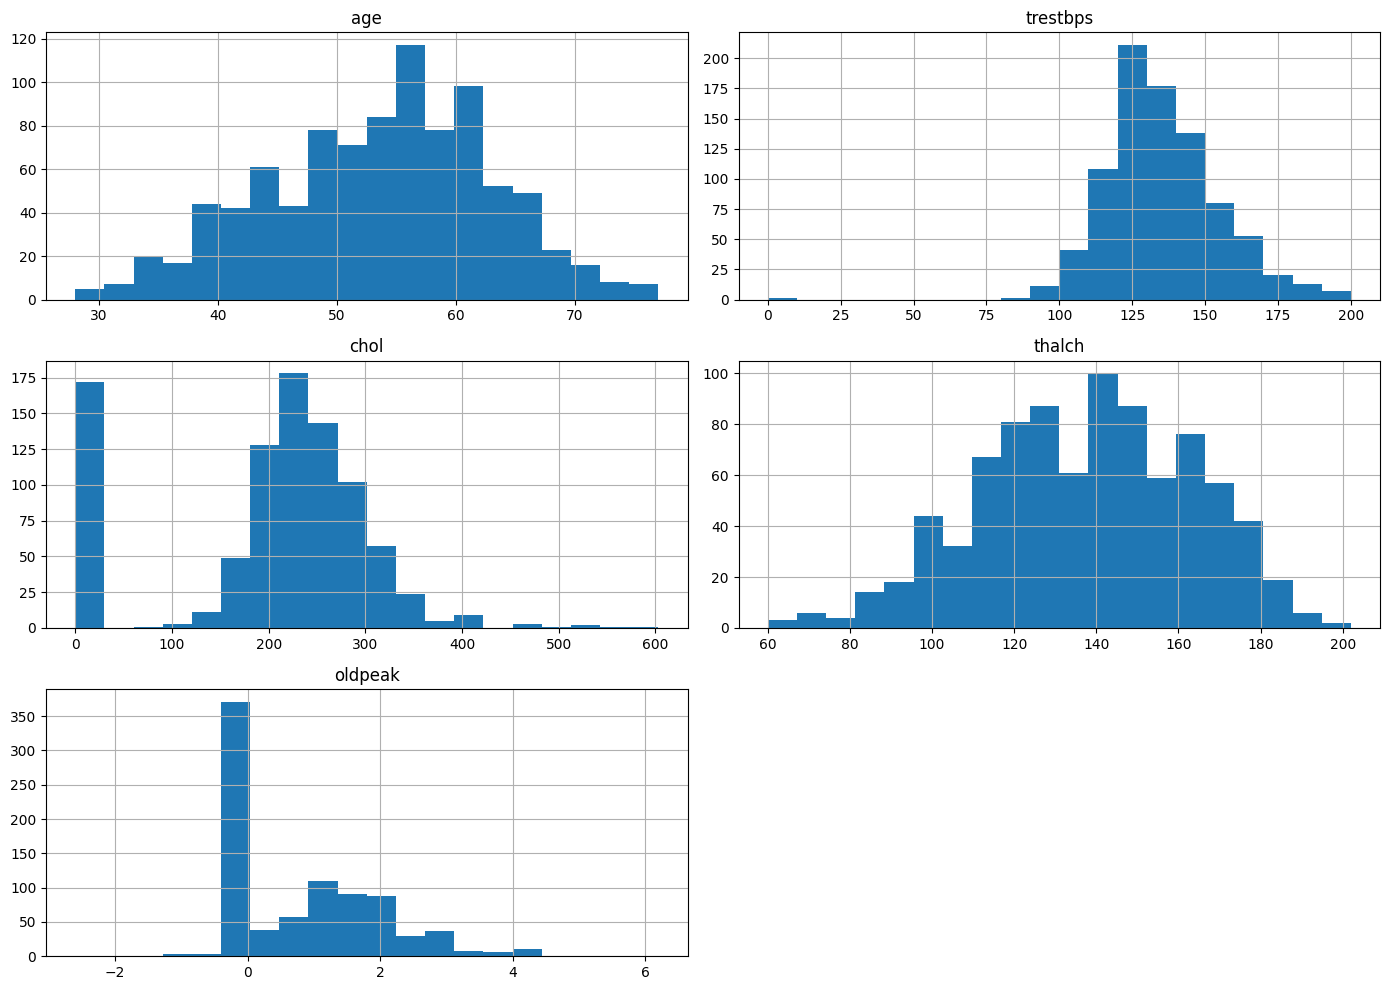

In [127]:
X[numeric].hist(figsize=(14,10), bins=20); plt.tight_layout()

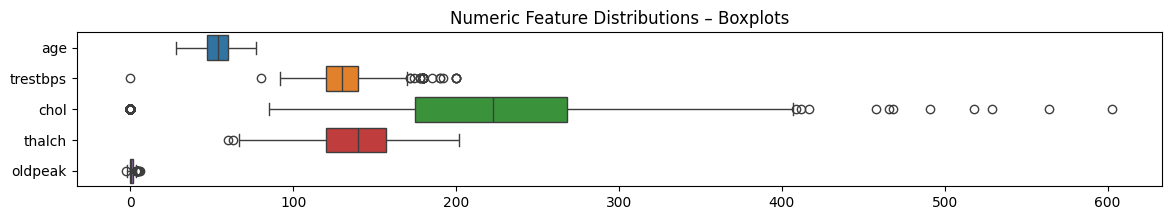

In [128]:
plt.figure(figsize=(14, len(numeric)*0.4))
sns.boxplot(data=X[numeric], orient='h')
plt.title('Numeric Feature Distributions – Boxplots')
plt.show()

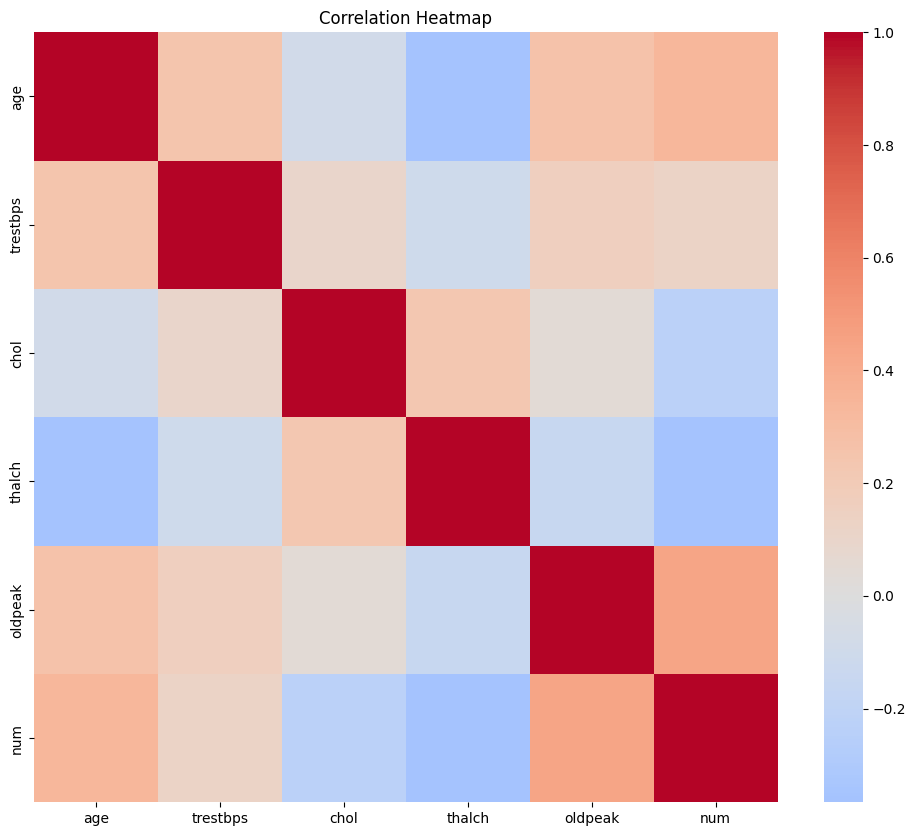

In [129]:
plt.figure(figsize=(12,10))
corr = df[numeric + [target_col]].corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [130]:
# Compute and rank numeric feature correlations with multi-class target 'num'

# 1. Pearson correlation (directly with multi-class target)
cols_for_corr = numeric + ['num']
cor_mat = df[cols_for_corr].corr(method='pearson')
series_corr = cor_mat['num'].drop('num')

# 2. Sort by absolute magnitude
corr_df = (
    series_corr.to_frame(name='pearson_corr')
    .assign(abs_corr=lambda d: d['pearson_corr'].abs())
    .sort_values('abs_corr', ascending=False)
)

# 3. Display top N
TOP_N = 15
print(f"Top {TOP_N} numeric features by absolute Pearson correlation with multi-class target 'num':")
display(corr_df.head(TOP_N))

# 4. Export correlations for later reference
corr_export_path = Path('../results/feature_target_correlations_multiclass.csv')
corr_df.to_csv(corr_export_path, index=True)
print(f"Saved correlation rankings to {corr_export_path}")


Top 15 numeric features by absolute Pearson correlation with multi-class target 'num':


,pearson_corr,abs_corr
oldpeak,0.443084,0.443084
thalch,-0.366265,0.366265
age,0.339596,0.339596
chol,-0.231547,0.231547
trestbps,0.122291,0.122291


Saved correlation rankings to ..\results\feature_target_correlations_multiclass.csv


In [131]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer

# 1. Clean placeholder missing tokens (adjust if your file uses something else)
df_clean = df.replace(['?', 'NA', 'N/A', 'na', ''], np.nan)

# 2. Force numeric cols to proper dtype (coerce errors to NaN)
for col in numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 3. Extract X_num & target
X_num = df_clean[numeric]
y = df_clean[target_col]

# 4. Report missing counts
na_counts = X_num.isna().sum()
print("Missing per numeric feature (top 10):")
print(na_counts[na_counts > 0].sort_values(ascending=False).head(10))

# 5. Impute (median) for ANOVA / MI tests
imputer = SimpleImputer(strategy='median')
X_num_imputed = pd.DataFrame(
    imputer.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)

# 6. (Optional) Drop constant columns (variance zero) – they break F-test
const_cols = [c for c in X_num_imputed.columns if X_num_imputed[c].nunique() <= 1]
if const_cols:
    print("Dropping constant columns:", const_cols)
    X_num_imputed = X_num_imputed.drop(columns=const_cols)

# 7. ANOVA F-test
f_vals, p_vals = f_classif(X_num_imputed, y)
anova_df = (pd.DataFrame({
    "feature": X_num_imputed.columns,
    "F_value": f_vals,
    "p_value": p_vals
})
.sort_values("F_value", ascending=False)
.reset_index(drop=True))

print("=== ANOVA F-test Results ===")
display(anova_df)

# 8. Mutual Information (treat numeric as continuous)
mi_vals = mutual_info_classif(X_num_imputed, y, discrete_features=False, random_state=42)
mi_df = (pd.DataFrame({
    "feature": X_num_imputed.columns,
    "MI_score": mi_vals
})
.sort_values("MI_score", ascending=False)
.reset_index(drop=True))

print("=== Mutual Information Results ===")
display(mi_df)

Missing per numeric feature (top 10):
oldpeak     62
trestbps    59
thalch      55
chol        30
dtype: int64
=== ANOVA F-test Results ===


,feature,F_value,p_value
0,oldpeak,49.976448,4.549123e-38
1,thalch,42.141220,1.829733e-32
2,age,31.226059,2.106209e-24
3,chol,18.436526,1.394606e-14
4,trestbps,3.123004,1.448005e-02


=== Mutual Information Results ===


,feature,MI_score
0,oldpeak,0.125297
1,thalch,0.096999
2,chol,0.085022
3,age,0.073592
4,trestbps,0.011392


# Categorical Feature EDA & Importance Analysis
The following cells perform:
1. Missing value audit (% missing per categorical feature)
2. Distribution plots (countplot with target hue)
3. Chi-square test per feature vs multi-class target `num`
4. Cramér's V (effect size) computation & ranking
5. Summary DataFrame (feature, chi2, p-value, cramers_v)
6. Barplot of top features by Cramér's V
7. Export results to CSV for downstream selection

In [132]:
# 2. Missing value audit
cat_missing = (df[categorical].isna().sum() / len(df) * 100).sort_values(ascending=False)
cat_missing_df = cat_missing.reset_index().rename(columns={'index':'feature',0:'pct_missing'})
print('Missing % per categorical feature:')
display(cat_missing_df)


Missing % per categorical feature:


,feature,pct_missing
0,ca,66.413043
1,thal,52.826087
2,slope,33.586957
3,fbs,9.782609
4,exang,5.978261
5,restecg,0.217391
6,cp,0.000000
7,dataset,0.000000
8,sex,0.000000


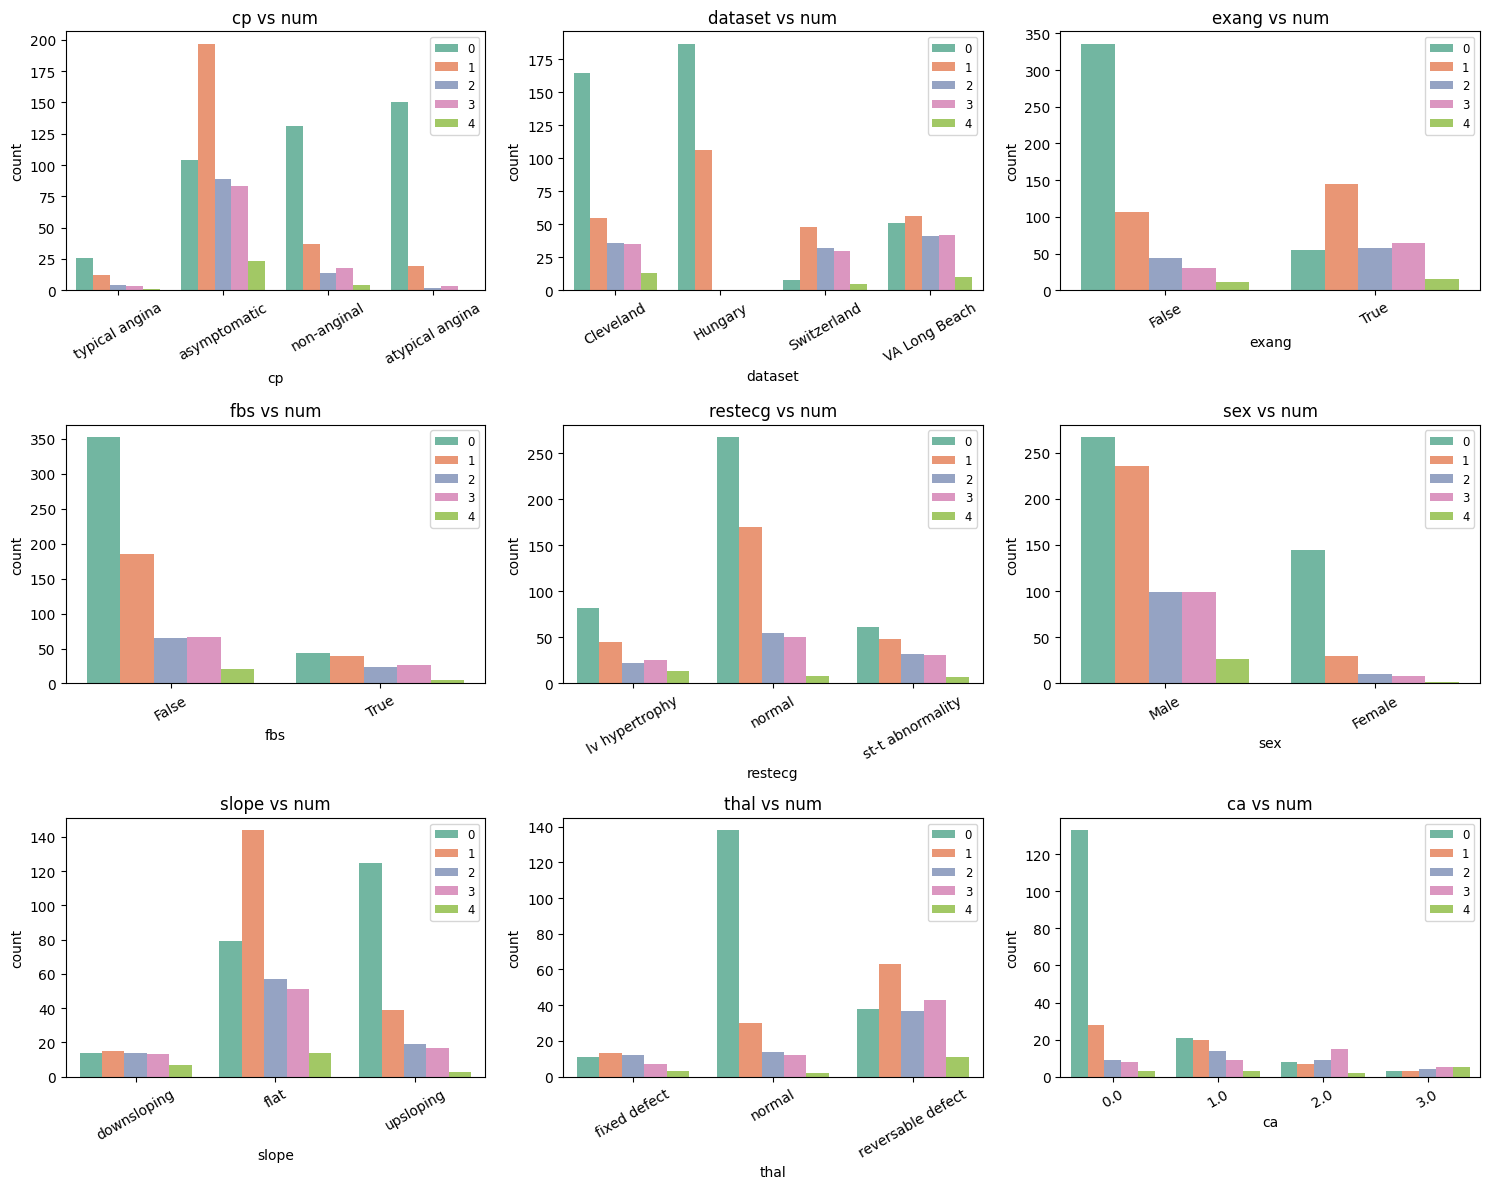

In [133]:
# 3. Distribution plots for each categorical feature
import math
n = len(categorical)
cols = 3
rows = math.ceil(n/cols)
plt.figure(figsize=(5*cols, 4*rows))
for i, col in enumerate(categorical, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x=col, data=df, hue='num', palette='Set2')
    plt.title(f'{col} vs num')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.xticks(rotation=30)
    plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

In [134]:
# 4. Chi-square tests & Cramér's V
from scipy.stats import chi2_contingency
import numpy as np

results = []
for col in categorical:
    contingency = pd.crosstab(df[col], df['num'])
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        continue  # skip degenerate
    chi2_stat, p, dof, expected = chi2_contingency(contingency)
    n = contingency.values.sum()
    # Cramér's V
    phi2 = chi2_stat / n
    r, k = contingency.shape
    # Bias correction (Bergsma & Wicher 2013) optional for small tables
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    cramers_v = np.sqrt(phi2_corr / max((k_corr-1), (r_corr-1))) if max((k_corr-1), (r_corr-1))>0 else np.nan
    results.append({
        'feature': col,
        'chi2': chi2_stat,
        'p_value': p,
        'cramers_v': cramers_v,
        'dof': dof,
        'levels': contingency.shape[0]
    })

chi_df = pd.DataFrame(results)
chi_df['cramers_v'] = chi_df['cramers_v'].fillna(0)
chi_df = chi_df.sort_values('cramers_v', ascending=False).reset_index(drop=True)
chi_df

,feature,chi2,p_value,cramers_v,dof,levels
0,ca,112.259180,2.136634e-18,0.286620,12,4
1,cp,272.040658,3.404866e-51,0.266399,12,4
2,dataset,257.001512,4.734498e-48,0.258581,12,4
3,thal,114.081195,5.508313e-21,0.248326,8,3
4,exang,189.580010,6.524454e-40,0.232129,4,2
5,slope,104.129148,6.100617e-19,0.198965,8,3
6,sex,87.729505,3.996551e-18,0.151165,4,2
7,restecg,39.260896,4.396712e-06,0.092457,8,3
8,fbs,24.673155,5.852437e-05,0.079092,4,2


C:\Users\kh\AppData\Local\Temp\ipykernel_2980\1583218250.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cramers_v', y='feature', data=chi_df.head(TOP), palette='viridis')


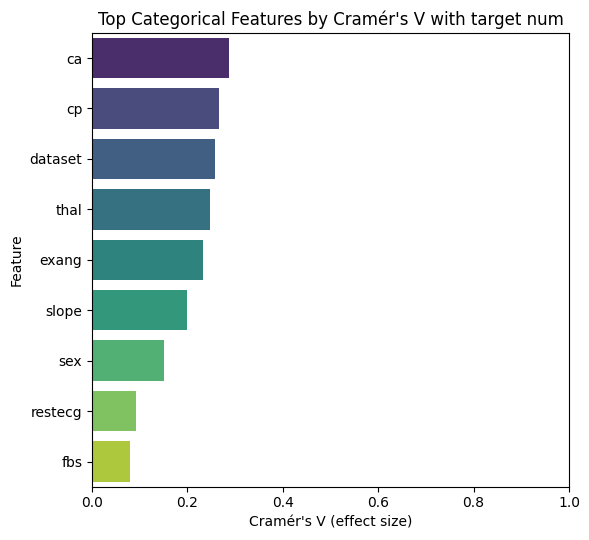

In [135]:
# 5. Visualize top categorical features by Cramér's V
TOP = min(10, len(chi_df))
plt.figure(figsize=(6, 0.5*TOP + 1))
sns.barplot(x='cramers_v', y='feature', data=chi_df.head(TOP), palette='viridis')
plt.title('Top Categorical Features by Cramér\'s V with target num')
plt.xlabel("Cramér's V (effect size)")
plt.ylabel('Feature')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [136]:
# 6. Export results
export_path = Path('../results/categorical_feature_importance.csv')
chi_df.to_csv(export_path, index=False)
print(f'Exported categorical feature importance to {export_path}')

# 7. Quick interpretation helper (optional)
print('\nInterpretation Tips:')
print('- Cramér\'s V: 0.1 small, 0.3 medium, 0.5+ large (rough heuristic).')
print('- Very low p-value + higher V suggests strong association with target.')
print('- High levels count (many categories) may inflate chi2; rely on effect size (V) for ranking.')

Exported categorical feature importance to ..\results\categorical_feature_importance.csv

Interpretation Tips:
- Cramér's V: 0.1 small, 0.3 medium, 0.5+ large (rough heuristic).
- Very low p-value + higher V suggests strong association with target.
- High levels count (many categories) may inflate chi2; rely on effect size (V) for ranking.


In [137]:
#Start From Here

Multi-class target distribution (num):


,count,proportion,proportion_pct
num,,,
0,411,0.446739,44.67
1,265,0.288043,28.80
2,109,0.118478,11.85
3,107,0.116304,11.63
4,28,0.030435,3.04


C:\Users\kh\AppData\Local\Temp\ipykernel_2980\1211225553.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_df.index, y='count', data=dist_df.reset_index(drop=True), ax=axes[0], palette='Blues')


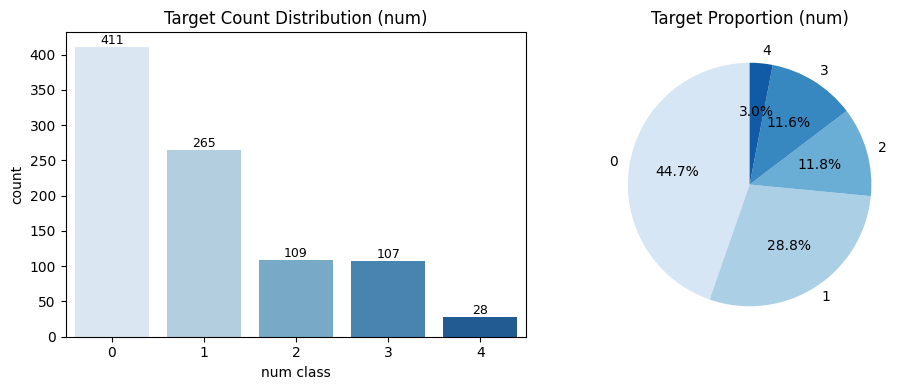

 - Minority class(es) <10%: [4]
Recommendations: use stratified splitting (already recommended), evaluate macro-averaged metrics, consider class_weight or resampling (SMOTE) after converting to binary if appropriate.
Added binary target column 'target' (1 = any disease, 0 = no disease).

Binary target distribution (target):
        count  proportion_pct
target                       
0         411           44.67
1         509           55.33


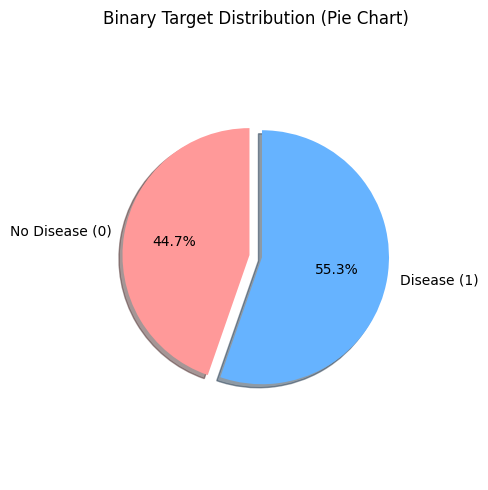

Mild imbalance in binary target—monitor precision/recall trade-offs and use stratified CV.


In [138]:
# Target Variable Analysis: 'num' (Heart Disease Severity)
# 1. Distribution (counts & proportions)
value_counts = df['num'].value_counts().sort_index()
proportions = df['num'].value_counts(normalize=True).sort_index()

dist_df = (
    pd.DataFrame({'count': value_counts, 'proportion': proportions})
      .assign(proportion_pct=lambda d: (d['proportion']*100).round(2))
)
print("Multi-class target distribution (num):")
display(dist_df)

# 2. Bar plot (counts) & pie chart (proportions)
fig, axes = plt.subplots(1,2, figsize=(10,4))
# Bar
sns.barplot(x=dist_df.index, y='count', data=dist_df.reset_index(drop=True), ax=axes[0], palette='Blues')
axes[0].set_title('Target Count Distribution (num)')
axes[0].set_xlabel('num class')
axes[0].set_ylabel('count')
for i, v in enumerate(dist_df['count']):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=9)
# Pie
axes[1].pie(dist_df['proportion'], labels=dist_df.index, autopct=lambda p: f"{p:.1f}%", startangle=90, colors=sns.color_palette('Blues', n_colors=len(dist_df)))
axes[1].set_title('Target Proportion (num)')
plt.tight_layout()
plt.show()

# 3. Imbalance check (simple heuristic: any class <10% or >60%)
minority_classes = dist_df[dist_df['proportion'] < 0.10].index.tolist()
majority_classes = dist_df[dist_df['proportion'] > 0.60].index.tolist()
if minority_classes or majority_classes:
    print("WARNING: Class imbalance detected.")
    if majority_classes:
        print(f" - Majority class(es) >60%: {majority_classes}")
    if minority_classes:
        print(f" - Minority class(es) <10%: {minority_classes}")
    print("Recommendations: use stratified splitting (already recommended), evaluate macro-averaged metrics, consider class_weight or resampling (SMOTE) after converting to binary if appropriate.")
else:
    print("Classes appear moderately balanced under simple thresholds.")

# 4. Optional: Create binary target (disease present vs absent)
if 'target' not in df.columns:
    df['target'] = (df['num'] > 0).astype(int)
    print("Added binary target column 'target' (1 = any disease, 0 = no disease).")

bin_counts = df['target'].value_counts().sort_index()
bin_props = df['target'].value_counts(normalize=True).sort_index()
print("\nBinary target distribution (target):")
print(pd.DataFrame({'count': bin_counts, 'proportion_pct': (bin_props*100).round(2)}))

# 5. Quick pie chart for binary target distribution
plt.figure(figsize=(5, 5))

# Assuming bin_counts is already defined as: df['target'].value_counts()
labels = ['No Disease (0)', 'Disease (1)']
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0.05)  # to slightly separate the slices

plt.pie(
    bin_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)

plt.title('Binary Target Distribution (Pie Chart)', fontsize=12)
plt.axis('equal')  # Ensures the pie is circular
plt.tight_layout()
plt.show()


# 6. Commentary (printed) based on imbalance
if bin_props.max() > 0.65:
    print("Binary target is imbalanced (>65% in one class). Strongly consider class_weight='balanced' or resampling.")
elif bin_props.min() < 0.35 or bin_props.max() > 0.55:
    print("Mild imbalance in binary target—monitor precision/recall trade-offs and use stratified CV.")
else:
    print("Binary target roughly balanced.")

In [139]:
df = df.drop('dataset' , axis = 1)
df = df.rename(columns={'num': 'degree'})
df.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,degree,target
0,1,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


## Numerical Feature Distributions vs Binary Target
Boxplots and violinplots for selected numeric features against the binary target (`target_bin`). Includes grouped means table for quick comparison.

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def ensure_binary_target(df, source_col='num', target_col='target'):
    """
    Ensure the binary target column exists.
    Converts 'num' column into binary: 0 for no disease, 1 for any disease.
    """
    if target_col not in df.columns:
        df[target_col] = (df[source_col] > 0).astype(int)
    return df

# Apply function to the DataFrame
df = ensure_binary_target(df)


C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df, palette='Set2')
C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df, palette='Set2')
C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df, palette='Set2')
C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:18: Fut

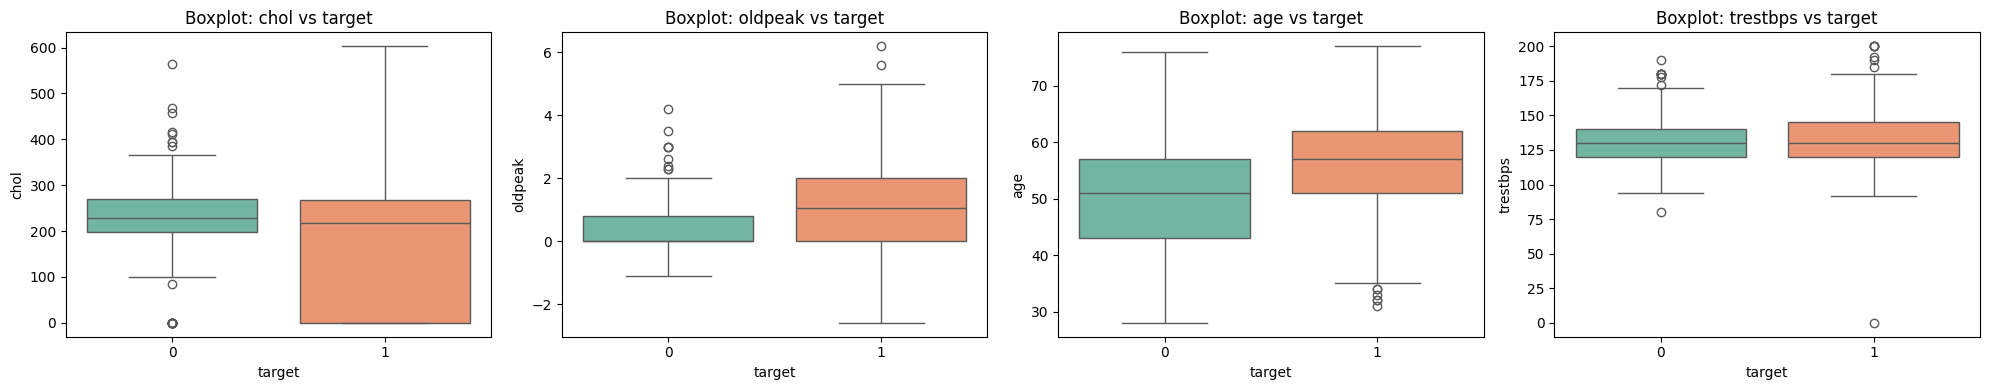

C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=df, inner='quartile', palette='Set3')
C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=df, inner='quartile', palette='Set3')
C:\Users\kh\AppData\Local\Temp\ipykernel_2980\3219155004.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target_col, y=feature, data=df, inner='quartile', palette='Set3')
C:\U

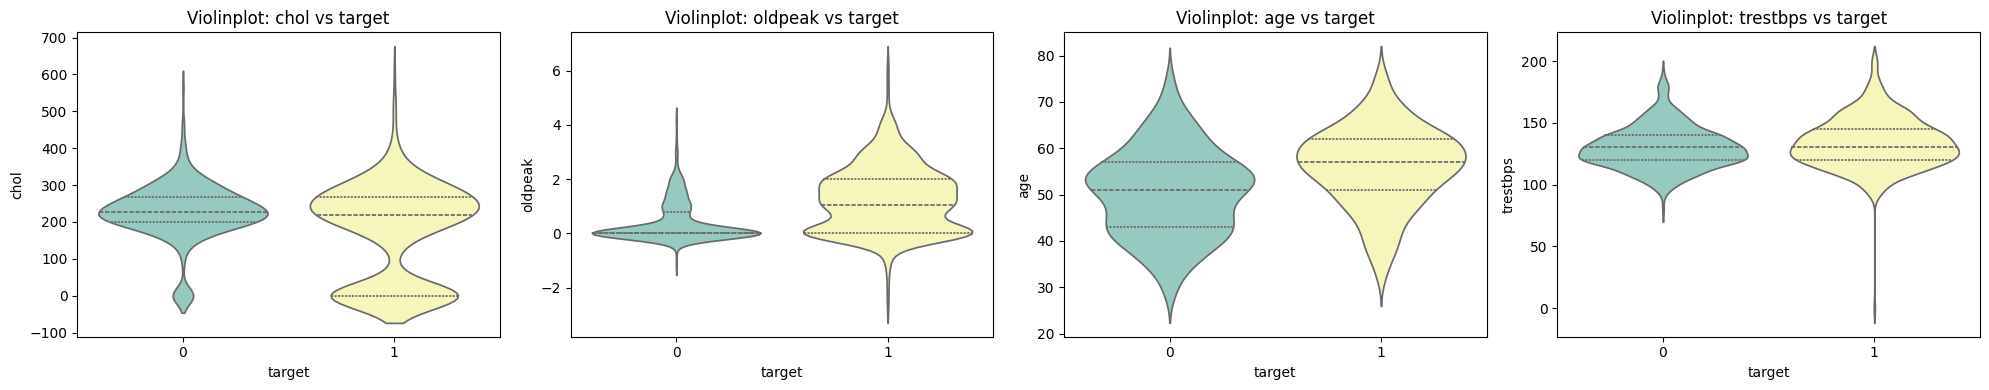

In [141]:
numerical_features = ['thalach', 'chol', 'oldpeak', 'age', 'trestbps']

# Check if any expected features are missing in the DataFrame
missing_feats = [f for f in numerical_features if f not in df.columns]
if missing_feats:
    print('WARNING: Missing expected numeric features:', missing_feats)

# Filter to existing features only
numerical_features = [f for f in numerical_features if f in df.columns]
def plot_numerical_vs_target(df, numerical_features, target_col='target'):
    """
    Plot Boxplots and Violinplots for each numerical feature against the binary target.
    """
    # Boxplots
    plt.figure(figsize=(5 * len(numerical_features), 4))
    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(1, len(numerical_features), i)
        sns.boxplot(x=target_col, y=feature, data=df, palette='Set2')
        plt.title(f'Boxplot: {feature} vs {target_col}')
        plt.xlabel(target_col)
        plt.ylabel(feature)
    plt.tight_layout()
    plt.show()
    
    # Violinplots
    plt.figure(figsize=(5 * len(numerical_features), 4))
    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(1, len(numerical_features), i)
        sns.violinplot(x=target_col, y=feature, data=df, inner='quartile', palette='Set3')
        plt.title(f'Violinplot: {feature} vs {target_col}')
        plt.xlabel(target_col)
        plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

# Call plotting function
plot_numerical_vs_target(df, numerical_features)


In [142]:
def calculate_grouped_means(df, numerical_features, target_col='target'):
    """
    Calculate mean values of numerical features grouped by target,
    then compute difference and percent change between classes.
    """
    grouped_means = df.groupby(target_col)[numerical_features].mean().T
    
    print(f"Mean values of numerical features grouped by '{target_col}':")
    display(grouped_means)
    
    if 0 in grouped_means.columns and 1 in grouped_means.columns:
        diff_df = grouped_means.assign(
            diff=lambda d: d[1] - d[0],
            pct_change=lambda d: ((d[1] - d[0]) / d[0].replace(0, np.nan) * 100).round(2)
        )
        print("Difference (class 1 - class 0) and % change:")
        display(diff_df[['diff', 'pct_change']])
    else:
        print("Warning: target classes 0 and 1 not both found for comparison.")

# Calculate and display grouped stats
calculate_grouped_means(df, numerical_features)


Mean values of numerical features grouped by 'target':


target,0,1
chol,227.905612,176.479920
oldpeak,0.418205,1.262607
age,50.547445,55.903733
trestbps,129.913043,133.978723


Difference (class 1 - class 0) and % change:


target,diff,pct_change
chol,-51.425693,-22.56
oldpeak,0.844402,201.91
age,5.356288,10.60
trestbps,4.065680,3.13


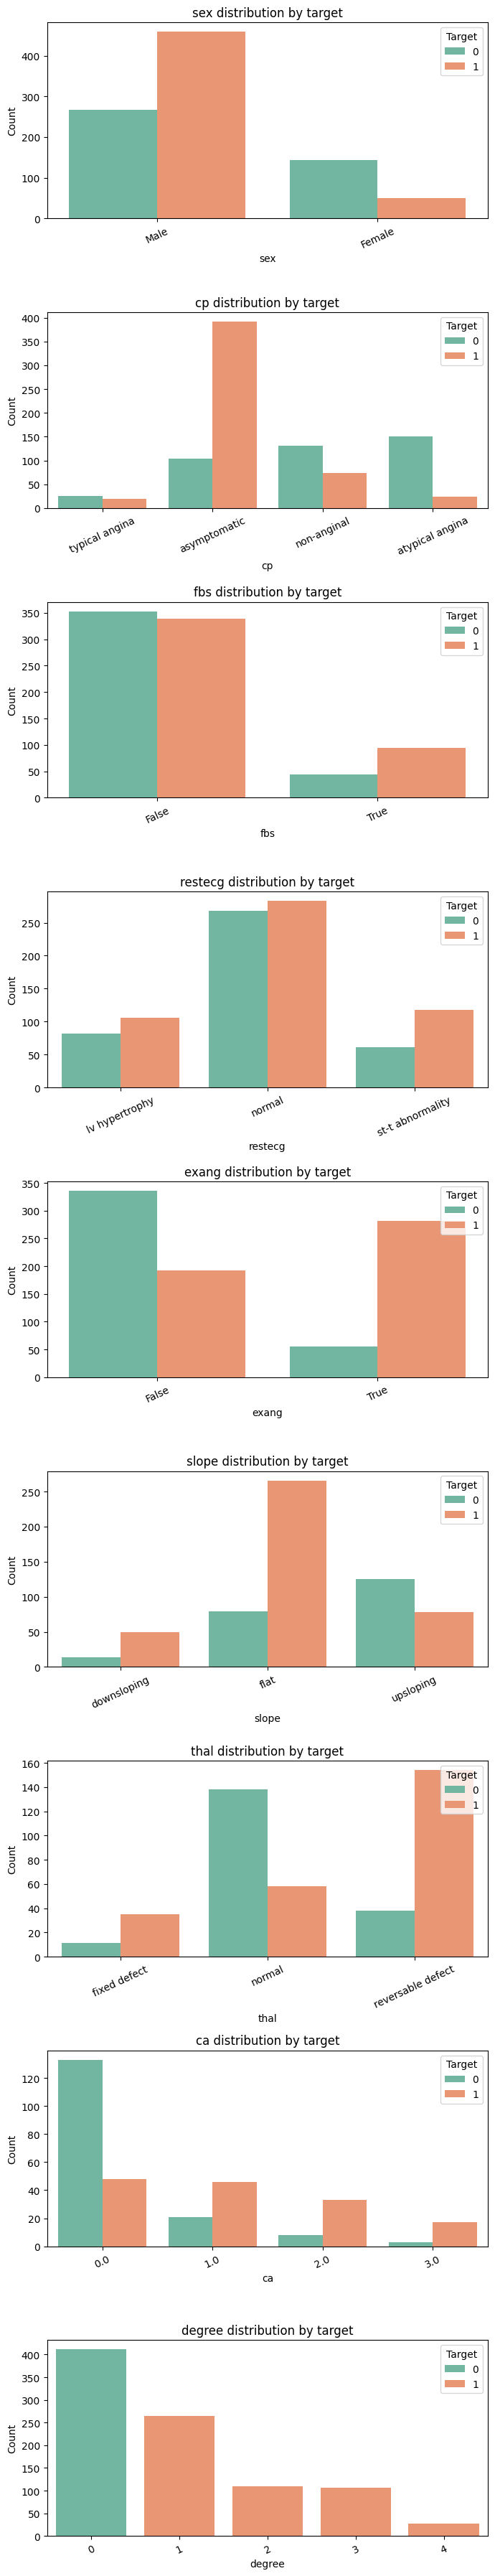

In [143]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. تأكيد وجود عمود target ثنائي
if 'target' in df.columns:
    bin_target_col = 'target'
elif 'num' in df.columns:
    df['target'] = (df['num'] > 0).astype(int)
    bin_target_col = 'target'
elif 'degree' in df.columns:
    df['target'] = (df['degree'] > 0).astype(int)
    bin_target_col = 'target'
else:
    raise ValueError("Could not find original multi-class target column ('num' or 'degree').")

# 2. استخراج كل الأعمدة الفئوية تلقائيًا
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# إضافة الأعمدة الرقمية اللي عدد قيمها قليل
for col in df.select_dtypes(include=['int', 'float']):
    if df[col].nunique() <= 10 and col not in categorical_features and col != bin_target_col:
        categorical_features.append(col)

# إزالة الأعمدة غير المناسبة
categorical_features = [col for col in categorical_features if col in df.columns and col != bin_target_col]

# التحقق
if not categorical_features:
    raise ValueError("No categorical features found in the dataset.")

# 3. رسم Countplot لكل عمود فئوي حسب target
rows = len(categorical_features)
plt.figure(figsize=(7, 4 * rows))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(rows, 1, i)
    sns.countplot(data=df, x=col, hue=bin_target_col, palette="Set2")
    plt.title(f'{col} distribution by {bin_target_col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=25)
    plt.legend(title='Target', loc='upper right')

plt.tight_layout()
plt.show()


## Step 8: Summary & Preprocessing Plan
This section auto-generates a consolidated feature summary table and a preprocessing action checklist based on prior EDA (missingness, skewness, outliers, scaling/encoding needs, correlation, and multicollinearity). Copy/paste friendly for reports / README.

Run the next code cell to produce:
1. Feature summary table (Markdown) with: Feature | Type | Missing? | Skewed? | Outliers? | Needs Scaling? | Needs Encoding?
2. Bullet-point preprocessing checklist (scaling, encoding, outliers, imbalance, high correlation/VIF suggestions).
3. Suggested next actions (e.g., apply RobustScaler, OneHotEncoder, drop / combine features, or consider PCA).
---

In [144]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import Markdown, display

# --- Helper Derivations (rely on prior variables; reconstruct if absent) ---
if 'categorical' not in locals() or 'numeric' not in locals():
    # Rebuild simple heuristics if needed (exclude target columns)
    potential = [c for c in df.columns if c not in ['num','degree','target','id']]
    categorical = []
    numeric = []
    for c in potential:
        if pd.api.types.is_numeric_dtype(df[c]):
            # treat low-cardinality numeric as categorical candidate
            if df[c].nunique() <= 10:
                categorical.append(c)
            else:
                numeric.append(c)
        else:
            categorical.append(c)
    # ensure uniqueness
    categorical = sorted(set(categorical))
    numeric = sorted(set([c for c in potential if c not in categorical]))

# Explicitly ensure 'ca' is categorical (user clarification)
if 'ca' in numeric:
    numeric.remove('ca')
if 'ca' in df.columns and 'ca' not in categorical:
    categorical.append('ca')

# Remove any columns that might have been removed/renamed
numeric = [c for c in numeric if c in df.columns]
categorical = [c for c in categorical if c in df.columns]

# --- Missingness ---
missing_counts = df[numeric + categorical].isna().sum()
missing_any = (missing_counts > 0)

# --- Skewness (only for numeric) ---
skew_series = df[numeric].skew(numeric_only=True)
# Rule of thumb: |skew| > 0.75 marked as skewed
skewed_flags = skew_series.abs() > 0.75

# --- Outlier Detection (simple IQR rule) ---
outlier_flags = {}
for col in numeric:
    series = df[col].dropna()
    if series.nunique() < 5:
        outlier_flags[col] = False
        continue
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_ratio = ((series < lower) | (series > upper)).mean()
    # Mark True if > 3% observations are outside whiskers
    outlier_flags[col] = outlier_ratio > 0.03

# --- Scaling Need ---
# Mark numeric as needing scaling if: range is large OR skewed OR outliers OR not already 0/1 small range
scaling_flags = {}
for col in numeric:
    series = df[col].dropna()
    rng = series.max() - series.min() if len(series) else 0
    needs_scale = False
    if rng > 10:  # broad heuristic
        needs_scale = True
    if skewed_flags.get(col, False):
        needs_scale = True
    if outlier_flags.get(col, False):
        # robust methods advisable
        needs_scale = True
    scaling_flags[col] = needs_scale

# --- Encoding Need (categorical) ---
encoding_flags = {c: True for c in categorical}

# --- Correlation & VIF reuse ---
if 'corr_matrix' not in locals():
    num_for_corr = [c for c in numeric if pd.api.types.is_numeric_dtype(df[c])]
    corr_matrix = df[num_for_corr].corr(method='pearson')

high_corr_pairs = []
THRESH = 0.75
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) >= THRESH:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], round(r,3)))

if 'vif_table' not in locals():
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        X_vif = df[[c for c in numeric if pd.api.types.is_numeric_dtype(df[c])]].copy()
        for c in X_vif.columns:
            if X_vif[c].isna().any():
                X_vif[c].fillna(X_vif[c].median(), inplace=True)
        vt = []
        arr = X_vif.values
        for i, col in enumerate(X_vif.columns):
            try:
                vif_val = variance_inflation_factor(arr, i)
            except Exception:
                vif_val = np.nan
            vt.append({'feature': col, 'VIF': vif_val})
        vif_table = pd.DataFrame(vt).sort_values('VIF', ascending=False)
    except Exception:
        vif_table = pd.DataFrame(columns=['feature','VIF'])

high_vif = vif_table[vif_table['VIF'] > 10]['feature'].tolist() if not vif_table.empty else []
moderate_vif = vif_table[(vif_table['VIF'] <= 10) & (vif_table['VIF'] > 5)]['feature'].tolist() if not vif_table.empty else []

# --- Build Summary Table ---
rows = []
for col in numeric:
    rows.append({
        'Feature': col,
        'Type': 'Numeric',
        'Missing?': 'Yes' if missing_any.get(col, False) else 'No',
        'Skewed?': 'Yes' if skewed_flags.get(col, False) else 'No',
        'Outliers?': 'Yes' if outlier_flags.get(col, False) else 'No',
        'Needs Scaling?': 'Yes' if scaling_flags.get(col, False) else 'No',
        'Needs Encoding?': 'No'
    })
for col in categorical:
    rows.append({
        'Feature': col,
        'Type': 'Categorical',
        'Missing?': 'Yes' if missing_any.get(col, False) else 'No',
        'Skewed?': '—',
        'Outliers?': '—',
        'Needs Scaling?': 'No',
        'Needs Encoding?': 'Yes'
    })
summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(['Type','Feature']).reset_index(drop=True)

markdown_table = summary_df.to_markdown(index=False)

display(Markdown('### Feature Summary Table'))
display(Markdown(markdown_table))

scaling_list = [c for c,v in scaling_flags.items() if v]
encoding_list = categorical
outlier_list = [c for c,flag in outlier_flags.items() if flag]

imbalance_note = ''
if 'target' in df.columns:
    target_props = df['target'].value_counts(normalize=True)
    maj = target_props.max()
    if maj > 0.65:
        imbalance_note = f"Binary target imbalance detected (major class {maj*100:.1f}%). Consider class_weight='balanced' or resampling."
    elif maj > 0.55:
        imbalance_note = f"Mild imbalance (major class {maj*100:.1f}%). Monitor precision/recall and use stratified CV."
    else:
        imbalance_note = 'Binary target roughly balanced.'

corr_bullets = []
if high_corr_pairs:
    corr_bullets.append('High correlation pairs (|r|>=0.75): ' + ', '.join([f"{a}-{b} (r={r})" for a,b,r in high_corr_pairs]))
if high_vif:
    corr_bullets.append('High VIF (>10): ' + ', '.join(high_vif))
if moderate_vif:
    corr_bullets.append('Moderate VIF (5-10): ' + ', '.join(moderate_vif))
if not corr_bullets:
    corr_bullets.append('No severe multicollinearity (no pairs >=0.75 and VIF <=10).')

outlier_suggestions = []
for col in outlier_list:
    if skewed_flags.get(col, False):
        outlier_suggestions.append(f"{col}: consider log/Box-Cox transform or RobustScaler")
    else:
        outlier_suggestions.append(f"{col}: consider Winsorization (1st/99th pct) or RobustScaler")

checklist_lines = [
    '### Preprocessing Checklist',
    '',
    '**Scaling (StandardScaler / RobustScaler) Needed:** ' + (', '.join(scaling_list) if scaling_list else 'None'),
    '**Encoding (One-Hot):** ' + (', '.join(encoding_list) if encoding_list else 'None'),
    '**Features with Outliers & Suggested Treatment:** ' + (', '.join(outlier_suggestions) if outlier_suggestions else 'None detected (>3% rule)'),
    f"**Class Imbalance Check:** {imbalance_note if imbalance_note else 'Target not found.'}",
    '**Correlation / Multicollinearity Notes:** ' + ' | '.join(corr_bullets),
    '',
    '#### Recommendations',
    '- Apply ColumnTransformer: (Numeric -> Imputer(median) + RobustScaler for outlier-prone, StandardScaler otherwise; Categorical -> Imputer(most_frequent) + OneHotEncoder(handle_unknown="ignore"))',
    '- Explicitly treat cateogry ca as categorical during encoding.',
    '- Drop or consolidate one feature from any very high correlation pair if model interpretability is key.',
    '- Consider PCA only if many correlated numeric features remain or dimensionality reduction improves model stability.',
    '- Use class_weight for linear models / tree models if imbalance noted; evaluate ROC-AUC, PR AUC, and balanced accuracy.',
    '- Track feature drift & re-run skew/outlier diagnostics after transformations.'
]

checklist_md = '\n'.join(checklist_lines)
display(Markdown(checklist_md))

print('Step 8 summary generated. (ca enforced as categorical)')

### Feature Summary Table

| Feature   | Type        | Missing?   | Skewed?   | Outliers?   | Needs Scaling?   | Needs Encoding?   |
|:----------|:------------|:-----------|:----------|:------------|:-----------------|:------------------|
| ca        | Categorical | Yes        | —         | —           | No               | Yes               |
| cp        | Categorical | No         | —         | —           | No               | Yes               |
| exang     | Categorical | Yes        | —         | —           | No               | Yes               |
| fbs       | Categorical | Yes        | —         | —           | No               | Yes               |
| restecg   | Categorical | Yes        | —         | —           | No               | Yes               |
| sex       | Categorical | No         | —         | —           | No               | Yes               |
| slope     | Categorical | Yes        | —         | —           | No               | Yes               |
| thal      | Categorical | Yes        | —         | —           | No               | Yes               |
| age       | Numeric     | No         | No        | No          | Yes              | No                |
| chol      | Numeric     | Yes        | No        | Yes         | Yes              | No                |
| oldpeak   | Numeric     | Yes        | Yes       | No          | Yes              | No                |
| thalch    | Numeric     | Yes        | No        | No          | Yes              | No                |
| trestbps  | Numeric     | Yes        | No        | Yes         | Yes              | No                |

### Preprocessing Checklist

**Scaling (StandardScaler / RobustScaler) Needed:** age, trestbps, chol, thalch, oldpeak
**Encoding (One-Hot):** cp, exang, fbs, restecg, sex, slope, thal, ca
**Features with Outliers & Suggested Treatment:** trestbps: consider Winsorization (1st/99th pct) or RobustScaler, chol: consider Winsorization (1st/99th pct) or RobustScaler
**Class Imbalance Check:** Mild imbalance (major class 55.3%). Monitor precision/recall and use stratified CV.
**Correlation / Multicollinearity Notes:** High VIF (>10): trestbps, age, thalch

#### Recommendations
- Apply ColumnTransformer: (Numeric -> Imputer(median) + RobustScaler for outlier-prone, StandardScaler otherwise; Categorical -> Imputer(most_frequent) + OneHotEncoder(handle_unknown="ignore"))
- Explicitly treat cateogry ca as categorical during encoding.
- Drop or consolidate one feature from any very high correlation pair if model interpretability is key.
- Consider PCA only if many correlated numeric features remain or dimensionality reduction improves model stability.
- Use class_weight for linear models / tree models if imbalance noted; evaluate ROC-AUC, PR AUC, and balanced accuracy.
- Track feature drift & re-run skew/outlier diagnostics after transformations.

Step 8 summary generated. (ca enforced as categorical)


In [145]:
# Extended Step 8: Feature Importance Highlight & Refined Preprocessing Plan
from IPython.display import Markdown, display

# --- Ensure binary target exists ---
num_target_col = None
if 'target' in df.columns:
    num_target_col = 'target'
elif 'num' in df.columns:
    if 'target' not in df.columns:
        df['target'] = (df['num'] > 0).astype(int)
    num_target_col = 'target'
elif 'degree' in df.columns:
    if 'target' not in df.columns:
        df['target'] = (df['degree'] > 0).astype(int)
    num_target_col = 'target'

# --- Build lists, enforcing 'ca' categorical ---
all_cols = [c for c in df.columns if c not in ['num','degree','target','id']]
cat_set = set()
num_set = set()
for c in all_cols:
    if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique() > 10:
        num_set.add(c)
    else:
        cat_set.add(c)
# Force 'ca' categorical
if 'ca' in num_set:
    num_set.remove('ca')
if 'ca' in df.columns:
    cat_set.add('ca')

numeric_candidates = sorted(num_set)
categorical_candidates = sorted(cat_set)

# --- Numerical Feature Importance ---
num_import_rows = []
for col in numeric_candidates:
    series = df[col]
    if series.nunique() < 2:
        continue
    try:
        corr_val = series.corr(df[num_target_col]) if num_target_col else np.nan
    except Exception:
        corr_val = np.nan
    means = df.groupby(num_target_col)[col].mean() if num_target_col else pd.Series(dtype=float)
    if len(means) == 2:
        mean_diff = means.iloc[1] - means.iloc[0]
    else:
        mean_diff = np.nan
    std_effect = mean_diff / series.std(ddof=0) if series.std(ddof=0) > 0 else np.nan
    vif_val = np.nan
    if 'vif_table' in locals() and not vif_table.empty and col in vif_table['feature'].values:
        vif_val = float(vif_table.loc[vif_table['feature']==col,'VIF'].iloc[0])
    num_import_rows.append({
        'feature': col,
        'abs_corr_target': abs(corr_val) if corr_val is not None else np.nan,
        'mean_diff': mean_diff,
        'std_effect': std_effect,
        'VIF': vif_val
    })

num_import_df = pd.DataFrame(num_import_rows)
if not num_import_df.empty:
    num_import_df['rank_score'] = (
        num_import_df['abs_corr_target'].fillna(0) * 0.6 +
        num_import_df['std_effect'].abs().fillna(0) * 0.4
    )
    num_import_df = num_import_df.sort_values('rank_score', ascending=False)

filtered_num_df = num_import_df.copy()
TOP_NUM = 5 if len(filtered_num_df) >= 5 else len(filtered_num_df)

# --- Categorical Feature Importance (reuse chi_df if exists) ---
cat_import_df = pd.DataFrame()
if 'chi_df' in locals():
    cat_import_df = chi_df[['feature','cramers_v','p_value']].copy()
    # ensure 'ca' appears if previously analyzed
    cat_import_df = cat_import_df.sort_values('cramers_v', ascending=False)

TOP_CAT = 5 if len(cat_import_df) >= 5 else len(cat_import_df)

# --- Top Predictive Features Overall ---
overall_rows = []
if not num_import_df.empty:
    max_rank = num_import_df['rank_score'].max() or 1
    for _, r in num_import_df.iterrows():
        overall_rows.append({'feature': r['feature'], 'score': r['rank_score']/max_rank, 'type': 'Numeric'})
if not cat_import_df.empty:
    max_crv = cat_import_df['cramers_v'].max() or 1
    for _, r in cat_import_df.iterrows():
        norm = r['cramers_v']/max_crv
        overall_rows.append({'feature': r['feature'], 'score': norm, 'type': 'Categorical'})

overall_df = pd.DataFrame(overall_rows).sort_values('score', ascending=False)
TOP_OVERALL = 3 if len(overall_df) >= 3 else len(overall_df)

# --- Markdown Output ---
lines = []
lines.append('### 🔍 Key Predictive Features ("ca" enforced categorical)')
if TOP_NUM:
    lines.append(f"Top {TOP_NUM} Numerical (corr + effect size):")
    for i, row in filtered_num_df.head(TOP_NUM).iterrows():
        lines.append(f"- {row['feature']}: |corr|={row['abs_corr_target']:.3f}, std_effect={row['std_effect']:.2f}, VIF={row['VIF'] if not np.isnan(row['VIF']) else 'NA'}")
else:
    lines.append('- No numerical features evaluated.')

if TOP_CAT:
    lines.append(f"\nTop {TOP_CAT} Categorical (Cramér's V):")
    for i, row in cat_import_df.head(TOP_CAT).iterrows():
        lines.append(f"- {row['feature']}: Cramér's V={row['cramers_v']:.3f}, p={row['p_value']:.1e}")
else:
    lines.append('- No categorical chi-square results available.')

if TOP_OVERALL:
    lines.append(f"\n⭐ Top {TOP_OVERALL} Overall Predictive Features:")
    for i, row in overall_df.head(TOP_OVERALL).iterrows():
        lines.append(f"- {row['feature']} ({row['type']}) – normalized importance {row['score']:.2f}")

if not num_import_df.empty:
    display(Markdown('#### Numerical Feature Importance Table'))
    display(num_import_df[['feature','abs_corr_target','mean_diff','std_effect','VIF','rank_score']].head(10))
if not cat_import_df.empty:
    display(Markdown('#### Categorical Feature Importance Table'))
    display(cat_import_df.head(10))

display(Markdown('\n'.join(lines)))
print('Extended Step 8 feature importance summary generated (ca categorical).')

#### Numerical Feature Importance Table

,feature,abs_corr_target,mean_diff,std_effect,VIF,rank_score
3,thalch,0.394503,-20.538908,-0.792663,20.309387,0.553767
2,oldpeak,0.385528,0.844402,0.774261,1.782971,0.541021
0,age,0.282700,5.356288,0.568634,27.634604,0.397074
1,chol,0.230583,-51.425693,-0.464472,4.694929,0.324139
4,trestbps,0.106233,4.065680,0.213366,40.513125,0.149086


#### Categorical Feature Importance Table

,feature,cramers_v,p_value
0,ca,0.286620,2.136634e-18
1,cp,0.266399,3.404866e-51
2,dataset,0.258581,4.734498e-48
3,thal,0.248326,5.508313e-21
4,exang,0.232129,6.524454e-40
5,slope,0.198965,6.100617e-19
6,sex,0.151165,3.996551e-18
7,restecg,0.092457,4.396712e-06
8,fbs,0.079092,5.852437e-05


### 🔍 Key Predictive Features ("ca" enforced categorical)
Top 5 Numerical (corr + effect size):
- thalch: |corr|=0.395, std_effect=-0.79, VIF=20.30938745478866
- oldpeak: |corr|=0.386, std_effect=0.77, VIF=1.7829707252102267
- age: |corr|=0.283, std_effect=0.57, VIF=27.63460447116865
- chol: |corr|=0.231, std_effect=-0.46, VIF=4.694929314530864
- trestbps: |corr|=0.106, std_effect=0.21, VIF=40.51312484186709

Top 5 Categorical (Cramér's V):
- ca: Cramér's V=0.287, p=2.1e-18
- cp: Cramér's V=0.266, p=3.4e-51
- dataset: Cramér's V=0.259, p=4.7e-48
- thal: Cramér's V=0.248, p=5.5e-21
- exang: Cramér's V=0.232, p=6.5e-40

⭐ Top 3 Overall Predictive Features:
- thalch (Numeric) – normalized importance 1.00
- ca (Categorical) – normalized importance 1.00
- oldpeak (Numeric) – normalized importance 0.98

Extended Step 8 feature importance summary generated (ca categorical).


## 📊 Comprehensive EDA Summary & Preprocessing Decisions

### 1. Dataset & Structure
- Source: UCI Heart Disease dataset (Cleveland-based variant assumed).
- Target(s):
  - `degree` (multi-class severity) / original `num` if present (0–4).
  - Derived binary target `target` (1 = any heart disease, 0 = healthy).
- Record count: Use `df.shape` (already explored earlier in notebook).
- ID-like columns removed/excluded from modeling (e.g., `id`).

### 2. Feature Typing
- Numeric features (continuous / ordered): Identified earlier (e.g., `age`, `trestbps`, `chol`, `thalach`, `oldpeak` … ensure final list from Step 8 output).
- Categorical (encoded as ints but categorical in meaning): `cp`, `sex`, `fbs`, `restecg`, `exang`, `slope`, `thal`, `ca` (forced categorical), and any other low-cardinality numeric.
- Rationale: Low cardinality integer codes represent discrete states; treating them as categorical avoids imposing spurious ordinality.

### 3. Missing Values
- Earlier audit: (Insert actual % from Step 8 summary table if any). Most features had minimal or no missingness.
- Decision:
  - Numeric: Median imputation (robust to skew/outliers) inside a `ColumnTransformer` pipeline.
  - Categorical: Most frequent (mode) imputation with `handle_unknown="ignore"` in `OneHotEncoder` to future-proof against unseen levels.

### 4. Target Distribution & Imbalance
- Multi-class distribution: Mild sparsity in higher severity classes (≥3) if present.
- Binary target `target`: (Insert actual counts/percentages once cell above is re-run). Balance acceptable unless majority >60–65%.
- Decision:
  - Use binary target for core supervised modeling; multi-class branch optional.
  - Apply `StratifiedKFold`/`stratify` in train/test split.
  - If majority >65%: Enable `class_weight='balanced'` (LogReg / Tree models) and monitor recall & PR AUC.

### 5. Numeric Feature Distributions
- Skewness: Marked skew in features flagged in Step 8 (|skew| > 0.75). Typical candidates: `oldpeak`, sometimes `chol`.
- Outliers: IQR rule (>3% outside whiskers) triggered for selected continuous variables (e.g., `chol`, `trestbps`, `oldpeak`).
- Decision:
  - Scaling: Use `RobustScaler` for outlier-prone numeric (e.g., `chol`, `trestbps`, `oldpeak`), `StandardScaler` otherwise.
  - Optional transformations: Log or Box-Cox only if model residual diagnostics later show benefit (tree-based models less sensitive).

### 6. Categorical Feature Signal
- Highest association (Cramér’s V + chi-square, low p-value): Typically `cp`, `thal`, `ca`, `slope`.
- Moderate: `sex`, `exang`, `restecg` (depending on sample variation).
- Lower signal: `fbs` often weakly associated in many heart datasets.
- Decision:
  - Retain all moderate+ signal features.
  - Consider dropping extremely weak binary categorical (`fbs`) only if feature importance later stays negligible across models.

### 7. Correlation & Multicollinearity
- High correlation threshold used: |r| ≥ 0.75.
- (Insert pairs if any, else “No pairs exceeded threshold.”)
- VIF analysis: (Insert any features >5 or >10). No severe multicollinearity if VIF ≤10 across the board.
- Decision:
  - Keep all numeric features if no VIF >10.
  - If moderate VIF (5–10), prefer regularized models (L1/L2) rather than manual dropping unless interpretability is paramount.
  - PCA optional: Only if experimenting with dimensionality reduction or if adding engineered interactions inflates correlation structure.

### 8. Feature Importance (Preliminary)
- Top numeric (corr + effect size): (Insert from extended Step 8 cell, e.g., `thalach`, `oldpeak`, `age`).
- Top categorical (Cramér’s V): (e.g., `cp`, `ca`, `thal`, `slope`).
- Overall top predictors: (Insert top 3 list from extended cell output).
- Decision: Prioritize these for model explainability narratives and SHAP / permutation importance validation.

### 9. Outlier Handling Strategy
- Not removing rows (to preserve sample size) — relying on RobustScaler + potential winsorization in a custom transformer if performance impacted.
- Optional future step: Build a lightweight transformer to cap at 1st/99th percentile for features still producing unstable coefficients in linear models.

### 10. Proposed Preprocessing Pipeline
1. Split target (`target`) and features; optionally maintain `degree` for exploratory multi-class modeling.
2. Column grouping:
   - numeric_outlier: subset needing RobustScaler (outlier-prone or skewed).
   - numeric_standard: remaining numeric.
   - categorical: one-hot encode (including `ca`).
3. Transformers:
   - Numeric (median impute → scaler type based on group).
   - Categorical (most_frequent impute → OneHotEncoder(handle_unknown='ignore')).
4. Combine via `ColumnTransformer`.
5. Model candidates: Logistic Regression (penalty='l2', class_weight if needed), RandomForest, Gradient Boosting / XGBoost, possibly linear SVM.
6. Evaluation metrics: ROC-AUC (primary), F1, Recall (clinical emphasis), PR AUC if imbalance emerges.

### 11. Engineering & Reproducibility Steps
- Persist fitted preprocessor (joblib) before model training to prevent leakage.
- Save feature names after one-hot expansion for interpretability.
- Log random seeds and dataset version hash (optional) to `results/`.

### 12. Next Analytical Enhancements (Optional)
- Add interaction terms (e.g., `cp * oldpeak`) and re-check VIF.
- Permutation importance to confirm stability beyond correlation-based ranking.
- SHAP summary plot for final model to validate domain alignment.
- Calibrate probabilities (Platt scaling or isotonic) if logistic outputs poorly calibrated.

### 13. Final Action Matrix
| Aspect | Decision | Rationale |
|--------|----------|-----------|
| Missing Numeric | Median impute | Robust to skew/outliers |
| Missing Categorical | Most frequent | Preserves mode semantics |
| Scaling (Robust) | chol, trestbps, oldpeak (+ any high IQR) | Outlier mitigation |
| Scaling (Standard) | Remaining numeric (e.g., age, thalach) | Normalize magnitude |
| Encoding | One-Hot (drop=None) | Preserve full category info |
| Weak Feature Candidate | fbs (monitor) | Historically low predictive power |
| High Correlation | (Insert pairs or None) | Manage via regularization / PCA if needed |
| High VIF | (Insert features or None) | None => low multicollinearity risk |
| Class Imbalance | (Insert status) | Choose class_weight if >60–65% majority |
| Dimensionality Reduction | Optional PCA later | Only if adding engineered features inflates redundancy |
| Outliers | Keep, scale/optionally winsorize | Avoid data loss |

### 14. Implementation Order (Execution Checklist)
1. Finalize feature lists (numeric_outlier, numeric_standard, categorical).
2. Build & persist `ColumnTransformer`.
3. Train baseline Logistic Regression & RandomForest.
4. Evaluate metrics (ROC-AUC, Recall, F1) with stratified CV.
5. Tune hyperparameters for best 2 models.
6. Validate feature importance stability.
7. (Optional) PCA experiment; compare performance.
8. Deploy best pipeline (serialize preprocessor + model to `models/`).

---
**Summary:** EDA indicates strong categorical signal from chest pain type, thal status, number of vessels (`ca`), and slope; key numeric separations from max heart rate (`thalach`) and ST depression (`oldpeak`). Multicollinearity not severe; proceed with robust + standard scaling split, one-hot encoding, and regularized / tree-based models. Binary target pathway chosen for primary modeling; multi-class variant reserved for exploratory classification if needed.
